# Предобработка датасета
Приведем датасет к виду text,paraphrase(для удобства возьмем один)

In [179]:
data = "/kaggle/input/paraphrases/chatgpt_paraphrases.csv"

In [180]:
import pandas as pd
import ast

In [181]:
df_n = pd.read_csv(data)
df_n

,text,paraphrases,category,source
0,What is the step by step guide to invest in sh...,['Can you provide a detailed procedure for inv...,question,quora
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,['Can you tell me about the history of the Koh...,question,quora
2,How can I increase the speed of my internet co...,['What are some ways to enhance my internet sp...,question,quora
3,Why am I mentally very lonely? How can I solve...,['What is causing my mental loneliness and how...,question,quora
4,"Which one dissolve in water quikly sugar, salt...","['Among sugar, salt, methane, and carbon dioxi...",question,quora
...,...,...,...,...
419192,He wants to see prices brought down across the...,['He desires a reduction in prices across all ...,sentence,cnn_news
419193,"Costs: The Department for Environment, Food an...","['The Department for Environment, Food and Rur...",sentence,cnn_news
419194,Details of the action on water bills are expec...,"[""Downing Street is expected to reveal specifi...",sentence,cnn_news
419195,Chancellor George Osborne signalled the govern...,"[""In a speech last month, Chancellor George Os...",sentence,cnn_news


In [183]:
df = df_n.iloc[:, :2]
df

,text,paraphrases
0,What is the step by step guide to invest in sh...,['Can you provide a detailed procedure for inv...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,['Can you tell me about the history of the Koh...
2,How can I increase the speed of my internet co...,['What are some ways to enhance my internet sp...
3,Why am I mentally very lonely? How can I solve...,['What is causing my mental loneliness and how...
4,"Which one dissolve in water quikly sugar, salt...","['Among sugar, salt, methane, and carbon dioxi..."
...,...,...
419192,He wants to see prices brought down across the...,['He desires a reduction in prices across all ...
419193,"Costs: The Department for Environment, Food an...","['The Department for Environment, Food and Rur..."
419194,Details of the action on water bills are expec...,"[""Downing Street is expected to reveal specifi..."
419195,Chancellor George Osborne signalled the govern...,"[""In a speech last month, Chancellor George Os..."


In [187]:
df['paraphrases'] = df['paraphrases'].apply(lambda x: ast.literal_eval(x)[0] if x else None)
df

SyntaxError: invalid syntax (<unknown>, line 1)

In [188]:
from sklearn.model_selection import train_test_split

**обрежем датасет, чтобы проверить работоспособность всего**

In [189]:
df = df[:1000]

In [190]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=42)

In [191]:
train_df

,text,paraphrases
29,How should I prepare for CA final law?,What are the best ways to get ready for CA fin...
535,What is an interesting fact that you know and ...,Can you share a fascinating piece of informati...
695,How light bend with gravity?,In what way does gravity cause the bending of ...
557,How do I start a successful private equity firm?,What are the steps to establish a profitable p...
836,How can I wake up early in the morning?,What are some ways to wake up early in the mor...
...,...,...
106,Have you ever heard of travel hacking?,Are you familiar with the concept of travel ha...
270,Why aren't there more apps like Word Lens?,What is the reason for the scarcity of apps si...
860,What can I do to improve my question on Quora?,How can I enhance my Quora inquiry?
435,Should I learn AngularJS 1.5 instead of Angula...,Is it better to learn AngularJS 1.5 instead of...


# Дообучение gpt с lora

In [192]:
!pip install --upgrade accelerate
!pip install peft
!pip install datasets

In [193]:
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import load_metric, Dataset
from torch.utils.data import DataLoader

from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType


In [194]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

In [199]:
train = tokenizer(train_df['text'].tolist(), truncation=True, padding=True)
test = tokenizer(test_df['text'].tolist(), truncation=True, padding=True)

In [200]:
def shift(input_ids):
   return [tokenizer.pad_token_id] + input_ids[:-1]

train['labels'] = [shift(ids) for ids in train['input_ids']]
test['labels'] = [shift(ids) for ids in test['input_ids']]

In [201]:
train_data = Dataset.from_dict(train)
test_data = Dataset.from_dict(test)

In [202]:
train_data

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800
})

In [203]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [204]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # task_type, token classification (TaskType.CAUSAL_LM)
    inference_mode=False,
    r=8,                           # r, the dimension of the low-rank matrices
    lora_alpha=16,                 # lora_alpha, scaling factor for the weight matrices
    lora_dropout=0.3,              # lora_dropout, dropout probability of the LoRA layers
    fan_in_fan_out=True,
    bias="lora_only"               # bias, set to only lora layers to train

)

In [205]:
lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.23643136409814364


In [206]:
training_args = TrainingArguments(
    'lora_with_gpt_2',
    num_train_epochs=400,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_num_workers=2,

    evaluation_strategy = "steps",
    logging_strategy="steps",
    save_strategy="steps",
    eval_steps=30,
    logging_steps=30,
    save_steps=30,

    learning_rate=1e-3,
    weight_decay=0.01,
    save_total_limit=10,
    report_to='none',

    load_best_model_at_end=True
)

In [207]:
import matplotlib.pyplot as plt

In [80]:
# !pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=0b9a4b6cc55dd3f250a8bb970f4e3b92bdedbd8a74f9d5934ef436ac59595ee7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [139]:
# from datasets import load_metric
# import numpy as np

# bleu_metric = load_metric('bleu')
# rouge_metric = load_metric('rouge')

In [140]:
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=-1)

#     decoded_preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions]
#     decoded_labels = [tokenizer.decode(label, skip_special_tokens=True) for label in labels]

#     decoded_preds = [[pred] for pred in decoded_preds]
#     decoded_labels = [[[label]] for label in decoded_labels]

#     bleu_score = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
#     rouge_score = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)

#     bleu = bleu_score.get('score', 0)  
#     rouge_l_fmeasure = rouge_score['rougeL'].mid.fmeasure  

#     return {"bleu": bleu, "rouge_l_fmeasure": rouge_l_fmeasure}


In [208]:
class TrainingLogger(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
#         self.bleu_scores = []
#         self.rouge_scores = []
        self.eval_steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_loss.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_loss.append(logs['eval_loss'])
            self.eval_steps.append(state.global_step)
#             self.bleu_scores.append(logs.get('eval_bleu', None))
#             self.rouge_scores.append(logs.get('eval_rougeL', None))  


In [209]:
logger = TrainingLogger()

In [210]:
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
#     compute_metrics=compute_metrics,
    callbacks=[logger]
)

In [211]:
train_output = trainer.train()
trainer.model.save_pretrained('finetuned_model')

Step,Training Loss,Validation Loss
30,3.084300,0.324948
60,0.177700,0.067156
90,0.089000,0.050923
120,0.078200,0.034397
150,0.063300,0.029268
180,0.062500,0.015355
210,0.056100,0.013854
240,0.052600,0.009387
270,0.049900,0.004843
300,0.044700,0.002499


Checkpoint destination directory lora_with_gpt_2/checkpoint-30 already exists and is non-empty.Saving will proceed but saved results may be invalid.


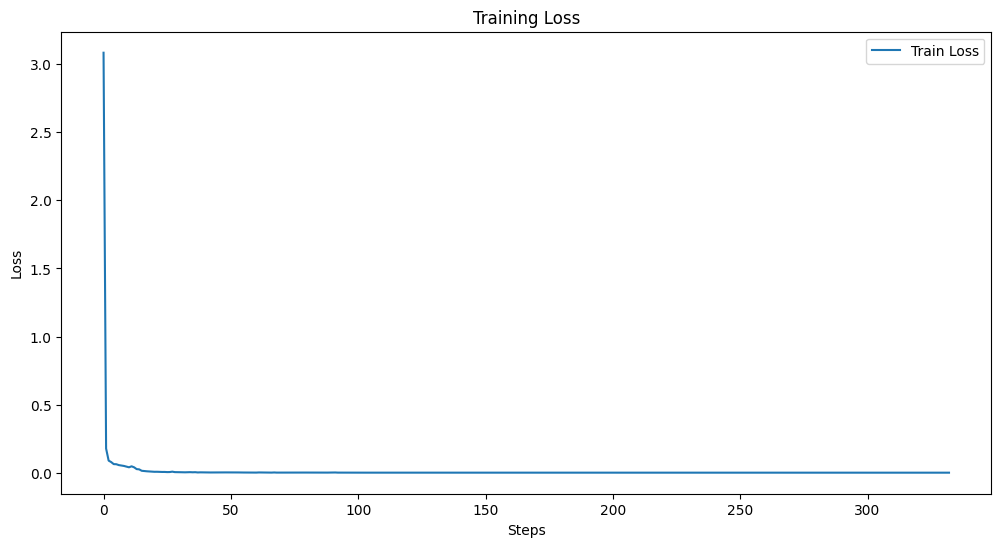

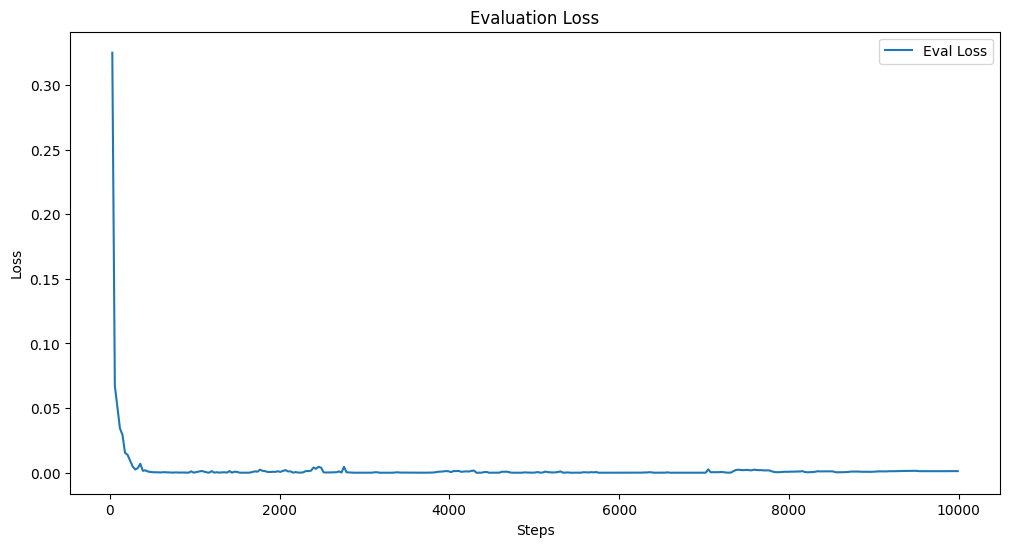

In [213]:
plt.figure(figsize=(12, 6))
plt.plot(logger.train_loss, label='Train Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(logger.eval_steps, logger.eval_loss, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()
plt.show()


In [214]:
trainer.model.save_pretrained("lora-gpt2")

In [216]:
eval_results = trainer.evaluate()
eval_results

{'eval_loss': 2.5651650048530428e-06,
 'eval_runtime': 0.7311,
 'eval_samples_per_second': 273.543,
 'eval_steps_per_second': 9.574,
 'epoch': 400.0}

In [217]:
from datasets import load_metric
import numpy as np

In [218]:
rouge_metric = load_metric('rouge')
bleu_metric = load_metric('bleu')

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu

# reference = [['это', 'эталонный', 'текст', 'на', 'русском']]
# candidate = ['это', 'сгенерированный', 'текст', 'на', 'русском']

# bleu_score = sentence_bleu(reference, candidate)
# print(f"BLEU Score: {bleu_score}")

In [222]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)

    decoded_preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions]
    decoded_labels = [tokenizer.decode(label, skip_special_tokens=True) for label in labels]

    decoded_preds = [[pred] for pred in decoded_preds]
    decoded_labels = [[[label]] for label in decoded_labels]

    bleu_score = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    rouge_score = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)

    bleu = bleu_score.get('score')  
    rouge_l_fmeasure = rouge_score['rougeL'].mid.fmeasure  

    return {"bleu": bleu, "rouge_l_fmeasure": rouge_l_fmeasure}


trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

eval_results = trainer.evaluate()

print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 2.5651650048530428e-06, 'eval_bleu': None, 'eval_rouge_l_fmeasure': 1.0, 'eval_runtime': 3.4888, 'eval_samples_per_second': 57.326, 'eval_steps_per_second': 2.006}
